<a href="https://colab.research.google.com/github/SashankGhimire/AI_CW/blob/main/AI_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import numpy as np


Google Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Load Dataset

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Dataset/UNSW_NB15_1.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Dataset/UNSW_NB15_2.csv")

#Merging Dataset
df = pd.concat([train_df, test_df], ignore_index=True)
print("Merged dataset shape:", df.shape)
df.head()

Merged dataset shape: (257673, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


Separate Features and Target Label

In [ ]:
y = df['label']
X = df.drop(columns=['label', 'attack_cat'], errors='ignore')

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (257673, 43)
y shape: (257673,)


Check Class Imblance

In [ ]:
print(y.value_counts())
print(y.value_counts(normalize=True))


label
1    164673
0     93000
Name: count, dtype: int64
label
1    0.639077
0    0.360923
Name: proportion, dtype: float64


Handle Missing Values

In [ ]:
X = X.fillna(0)

Remove Non-Informative Features

In [ ]:
X = X.drop(columns=['srcip', 'dstip'], errors='ignore')
print("After removing IPs:", X.shape)


After removing IPs: (257673, 43)


Encode Categorical Features

In [ ]:
categorical_cols = X.select_dtypes(include='object').columns.tolist()
print("Categorical columns:", categorical_cols)

X = pd.get_dummies(X, columns=categorical_cols)
print("After encoding:", X.shape)


Categorical columns: ['proto', 'service', 'state']
After encoding: (257673, 197)


Feature Scaling

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Train–Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (206138, 197)
Test shape: (51535, 197)


In [ ]:
dt = DecisionTreeClassifier(
    random_state=45,
    class_weight='balanced'
)

dt.fit(X_train, y_train)


DecisionTreeClassifier(class_weight='balanced', random_state=45)

In [ ]:
y_pred = dt.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Decision Tree Accuracy: 0.9841078878432133

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     18600
           1       0.99      0.99      0.99     32935

    accuracy                           0.98     51535
   macro avg       0.98      0.98      0.98     51535
weighted avg       0.98      0.98      0.98     51535



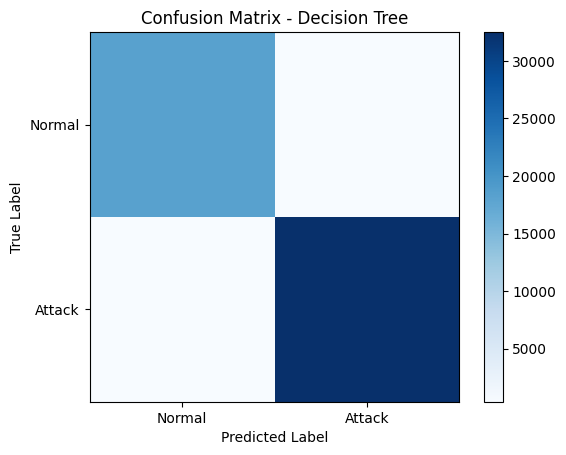

In [ ]:
cm_dt = confusion_matrix(y_test, y_pred)

plt.figure()
plt.imshow(cm_dt, cmap='Blues')
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.xticks([0, 1], ['Normal', 'Attack'])
plt.yticks([0, 1], ['Normal', 'Attack'])

plt.colorbar()
plt.show()

Visualization For Decision Tree

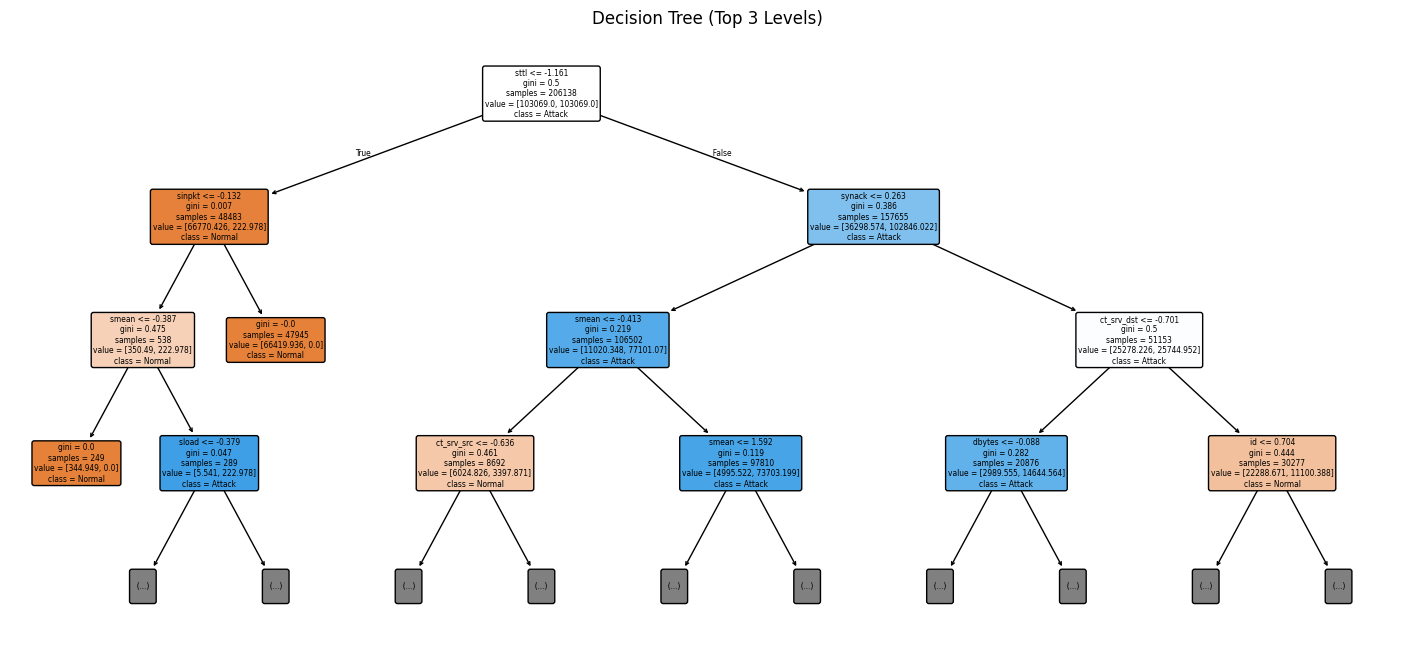

In [ ]:
plt.figure(figsize=(18, 8))

# max_depth limits the displayed depth so it doesn't become messy
plot_tree(
    dt,
    max_depth=3,             # show only first 3 levels (readable)
    filled=True,             # color nodes
    rounded=True,            # rounded boxes
    class_names=["Normal", "Attack"],  # label classes
    feature_names=X.columns  # feature names after encoding
)

plt.title("Decision Tree (Top 3 Levels)")
plt.show()

Feature Importance Top 15

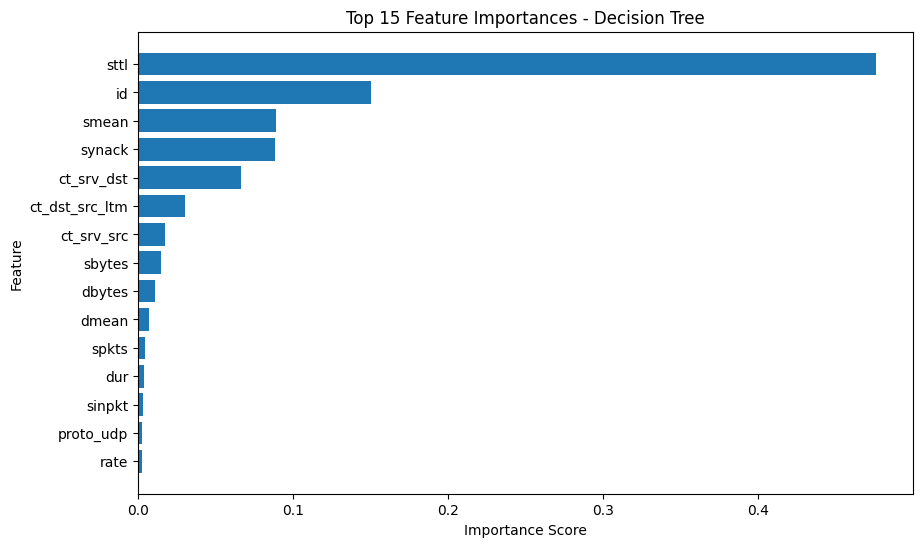

In [ ]:
# Get feature importance values from trained decision tree
importances = dt.feature_importances_

# Create a dataframe (feature + importance)
feat_imp = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
})

# Sort descending and take top 15
feat_imp = feat_imp.sort_values(by="Importance", ascending=False).head(15)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp["Feature"][::-1], feat_imp["Importance"][::-1])  # reverse for best on top
plt.title("Top 15 Feature Importances - Decision Tree")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

ROC Curve

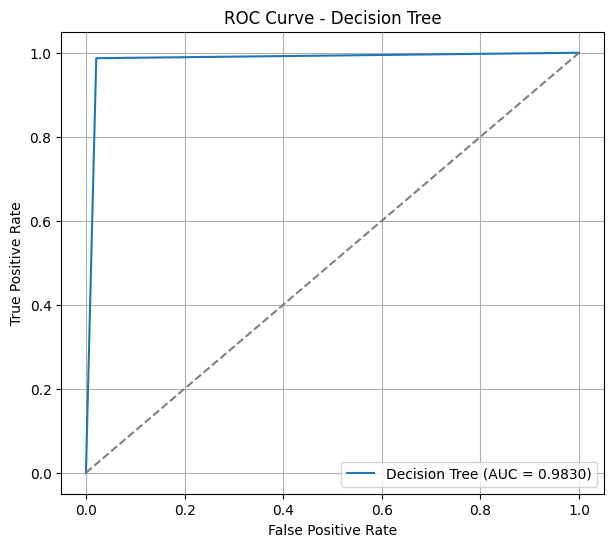

In [ ]:
# Step 1: Get prediction probabilities for the positive class (Attack = 1)
y_prob = dt.predict_proba(X_test)[:, 1]

# Step 2: Calculate False Positive Rate and True Positive Rate
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Step 3: Calculate Area Under Curve (AUC)
roc_auc = auc(fpr, tpr)

# Step 4: Plot ROC Curve
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"Decision Tree (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier line

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Random Forest

In [ ]:
rf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',
    n_estimators=100
)

rf.fit(X_train, y_train)



RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
y_pred_rf = rf.predict(X_test)

In [ ]:
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.9765984282526439
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     18600
           1       0.98      0.98      0.98     32935

    accuracy                           0.98     51535
   macro avg       0.97      0.97      0.97     51535
weighted avg       0.98      0.98      0.98     51535



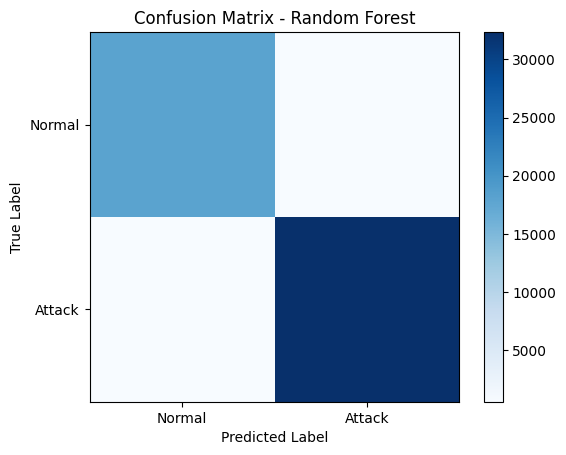

In [ ]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure()
plt.imshow(cm_rf, cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.xticks([0, 1], ['Normal', 'Attack'])
plt.yticks([0, 1], ['Normal', 'Attack'])

plt.colorbar()
plt.show()


Visualization For Random Forest

ROC Curve

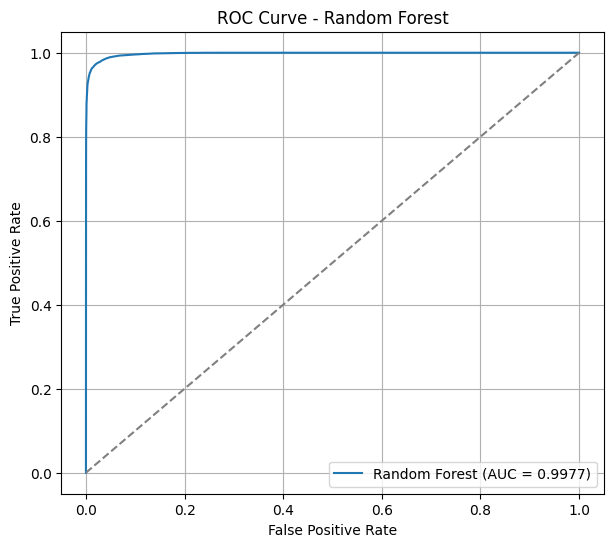

In [ ]:
# Step 1: Get prediction probabilities (Attack = 1)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Step 2: Compute FPR and TPR
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

# Step 3: Compute AUC
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Step 4: Plot ROC curve
plt.figure(figsize=(7, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Feature Importance (Top 15)

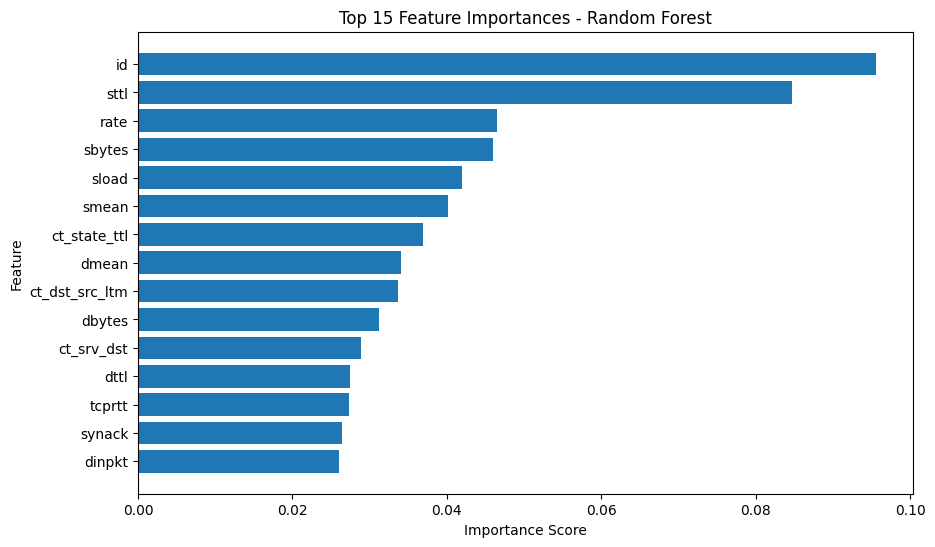

In [ ]:

# Step 1: Extract feature importances
rf_importances = rf.feature_importances_

# Step 2: Create dataframe
rf_feat_imp = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_importances
})

# Step 3: Sort and select top 15
rf_feat_imp = rf_feat_imp.sort_values(by="Importance", ascending=False).head(15)

# Step 4: Plot bar chart
plt.figure(figsize=(10, 6))
plt.barh(rf_feat_imp["Feature"][::-1], rf_feat_imp["Importance"][::-1])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 15 Feature Importances - Random Forest")
plt.show()

SVM Support Vector Machine

In [ ]:
svm = LinearSVC(
    class_weight='balanced',
    random_state=42,
    max_iter=5000
)

svm.fit(X_train, y_train)

LinearSVC(class_weight='balanced', max_iter=5000, random_state=42)

In [ ]:
y_pred_svm = svm.predict(X_test)

In [ ]:
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.9077326089065684
              precision    recall  f1-score   support

           0       0.85      0.90      0.88     18600
           1       0.94      0.91      0.93     32935

    accuracy                           0.91     51535
   macro avg       0.90      0.91      0.90     51535
weighted avg       0.91      0.91      0.91     51535



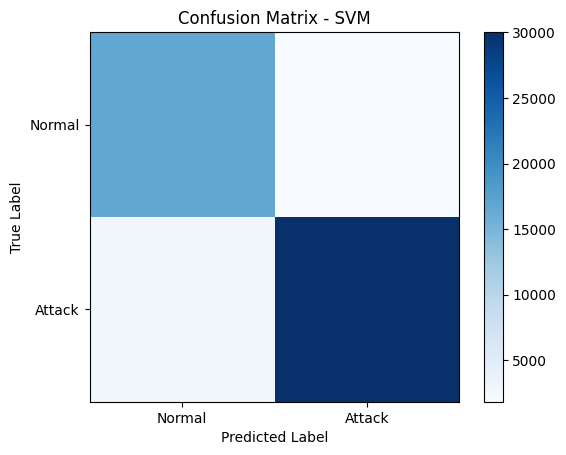

In [ ]:
cm = confusion_matrix(y_test, y_pred_svm)

plt.figure()
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.xticks([0, 1], ['Normal', 'Attack'])
plt.yticks([0, 1], ['Normal', 'Attack'])

plt.colorbar()
plt.show()


Decision Score Distribution

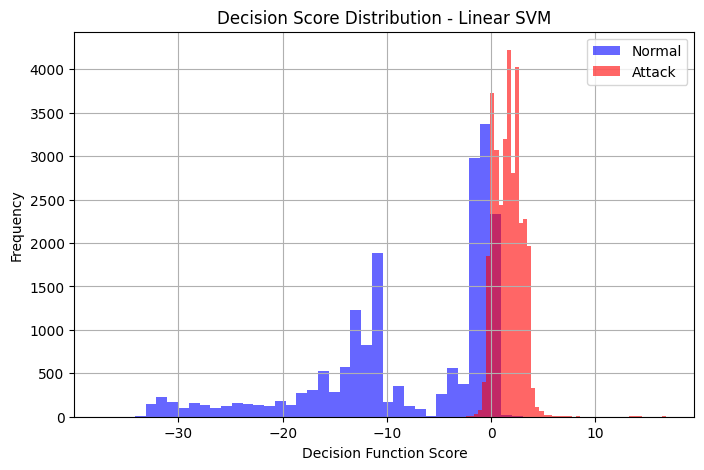

In [ ]:
# Get decision scores
decision_scores = svm.decision_function(X_test)

# Separate scores by class
scores_normal = decision_scores[y_test == 0]
scores_attack = decision_scores[y_test == 1]

# Plot histograms
plt.figure(figsize=(8, 5))
plt.hist(scores_normal, bins=50, alpha=0.6, label="Normal", color="blue")
plt.hist(scores_attack, bins=50, alpha=0.6, label="Attack", color="red")

plt.xlabel("Decision Function Score")
plt.ylabel("Frequency")
plt.title("Decision Score Distribution - Linear SVM")
plt.legend()
plt.grid(True)
plt.show()

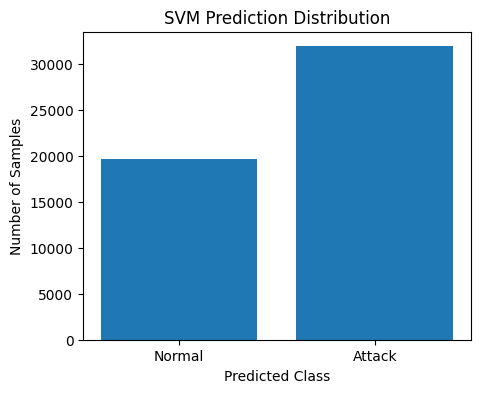

In [ ]:
# Get predictions from SVM
y_pred_svm = svm.predict(X_test)

# Count predictions
counts = [sum(y_pred_svm == 0), sum(y_pred_svm == 1)]

# Plot bar chart
plt.figure(figsize=(5,4))
plt.bar(["Normal", "Attack"], counts)

plt.xlabel("Predicted Class")
plt.ylabel("Number of Samples")
plt.title("SVM Prediction Distribution")
plt.show()

All Model in Action

Select a few real test samples

In [ ]:
# Select first 5 samples from test set
sample_X = X_test[:5]
sample_y = y_test[:5]


Make predictions using ALL models

In [ ]:
# Decision Tree prediction
dt_pred = dt.predict(sample_X)

# Random Forest prediction
rf_pred = rf.predict(sample_X)

# SVM prediction
svm_pred = svm.predict(sample_X)

Result

In [ ]:
import pandas as pd

results = pd.DataFrame({
    "Actual Label": sample_y.values,
    "Decision Tree": dt_pred,
    "Random Forest": rf_pred,
    "SVM": svm_pred,
})

results


,Actual Label,Decision Tree,Random Forest,SVM
0,1,1,1,1
1,0,0,1,0
2,0,0,0,0
3,1,1,1,1
4,1,1,1,1


Neural network

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report


In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


Create and train the Neural Network

In [ ]:
# Simple Neural Network (Multi-Layer Perceptron)
nn = MLPClassifier(
    hidden_layer_sizes=(64, 32),  # 2 hidden layers
    activation="relu",
    solver="adam",
    max_iter=20,                  # Can Increase to 50 or 100
    random_state=42
)

nn.fit(X_train_scaled, y_train)
print("Neural Network trained")


Neural Network trained


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Predict and evaluate

In [ ]:
y_pred_nn = nn.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred_nn))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_nn))


Accuracy: 0.9713786746871058

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.98      0.96     18600
           1       0.99      0.97      0.98     32935

    accuracy                           0.97     51535
   macro avg       0.97      0.97      0.97     51535
weighted avg       0.97      0.97      0.97     51535

